# Problem Definition
Using limit order book and executed trades data from the previous *WINDOW_LENGTH* seconds, identify whether a trade (long or short) placed now will return 25 basis points or more (before fees, slippage and other costs) in the next *HORIZON* seconds.

In this notebook we'll use a regression approach rather than a classification approach, so the task is not to predict extremely rare events, but to predict the future mid-price, which is arguably easier.

In [41]:
#Parameters
WINDOW_LENGTH = 15
HORIZON = 15
THRESHOLD = 0.0025

# Things to be implemented in v3

* How to use tradebook data? Maybe can create a pseudo-volatility feature which is high when there are many large volume trades placed recently, and is low otherwise.

* Try autoencoders?

---

Some (re)sources 
* https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
* http://karpathy.github.io/2019/04/25/recipe/
    * 'a “fast and furious” approach to training neural networks does not work and only leads to suffering. Now, suffering is a perfectly natural part of getting a neural network to work well, but it can be mitigated by being thorough, defensive, paranoid, and obsessed with visualizations of basically every possible thing. The qualities that in my experience correlate most strongly to success in deep learning are patience and attention to detail'

* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
* DeepLOB.pdf and Ntakaris.pdf seem especially useful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

plt.style.use('dark_background')

In [24]:
ob_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_orderbook.csv') #train orderbook
tb_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_trades.csv')#train tradebook

ob_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_orderbook.csv') #test orderbook 
tb_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_trades.csv')#test tradebook

In [3]:
'''
#Subset for testing 
ob_train = ob_train.head(10000)
ob_test = ob_test.head(10000)
'''

# Data exploration
We only explore the training set. Peeking into the test set results in look-ahead bias.

## Limit order book

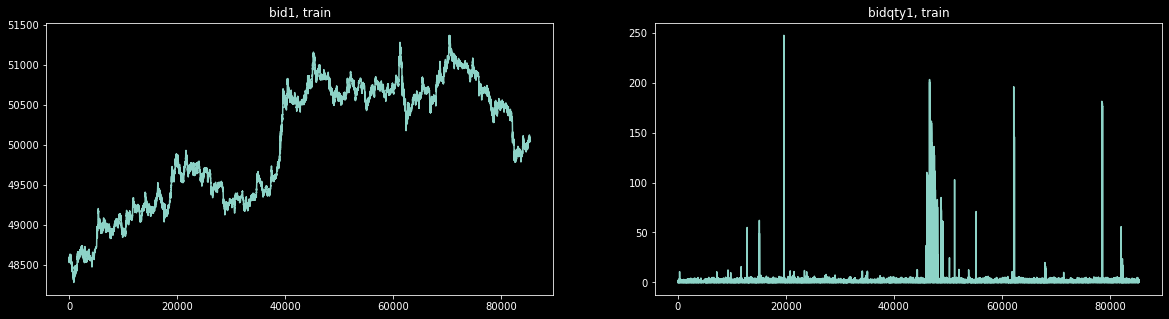

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("bid1, train")
ax[0].plot(ob_train['bid1'])
ax[1].set_title("bidqty1, train")
ax[1].plot(ob_train['bidqty1'])

In [39]:
#time difference in seconds between consecutive rows of train orderbook
time_difference = np.diff(pd.to_datetime(ob_train['timestamp']).astype('int').to_numpy())/(1000000000)

print("Mean: ", np.mean(time_difference), "\nStandard deviation: ", np.std(time_difference))
print("Max: ", np.max(time_difference))

#There's a ~6 minute gap between row 68673 and 68674 of ob_train.
#Apart from this, the data is essentially contiguous. 

Mean:  1.007023328983589 
Standard deviation:  1.3061452462652685
Max:  381.767076


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

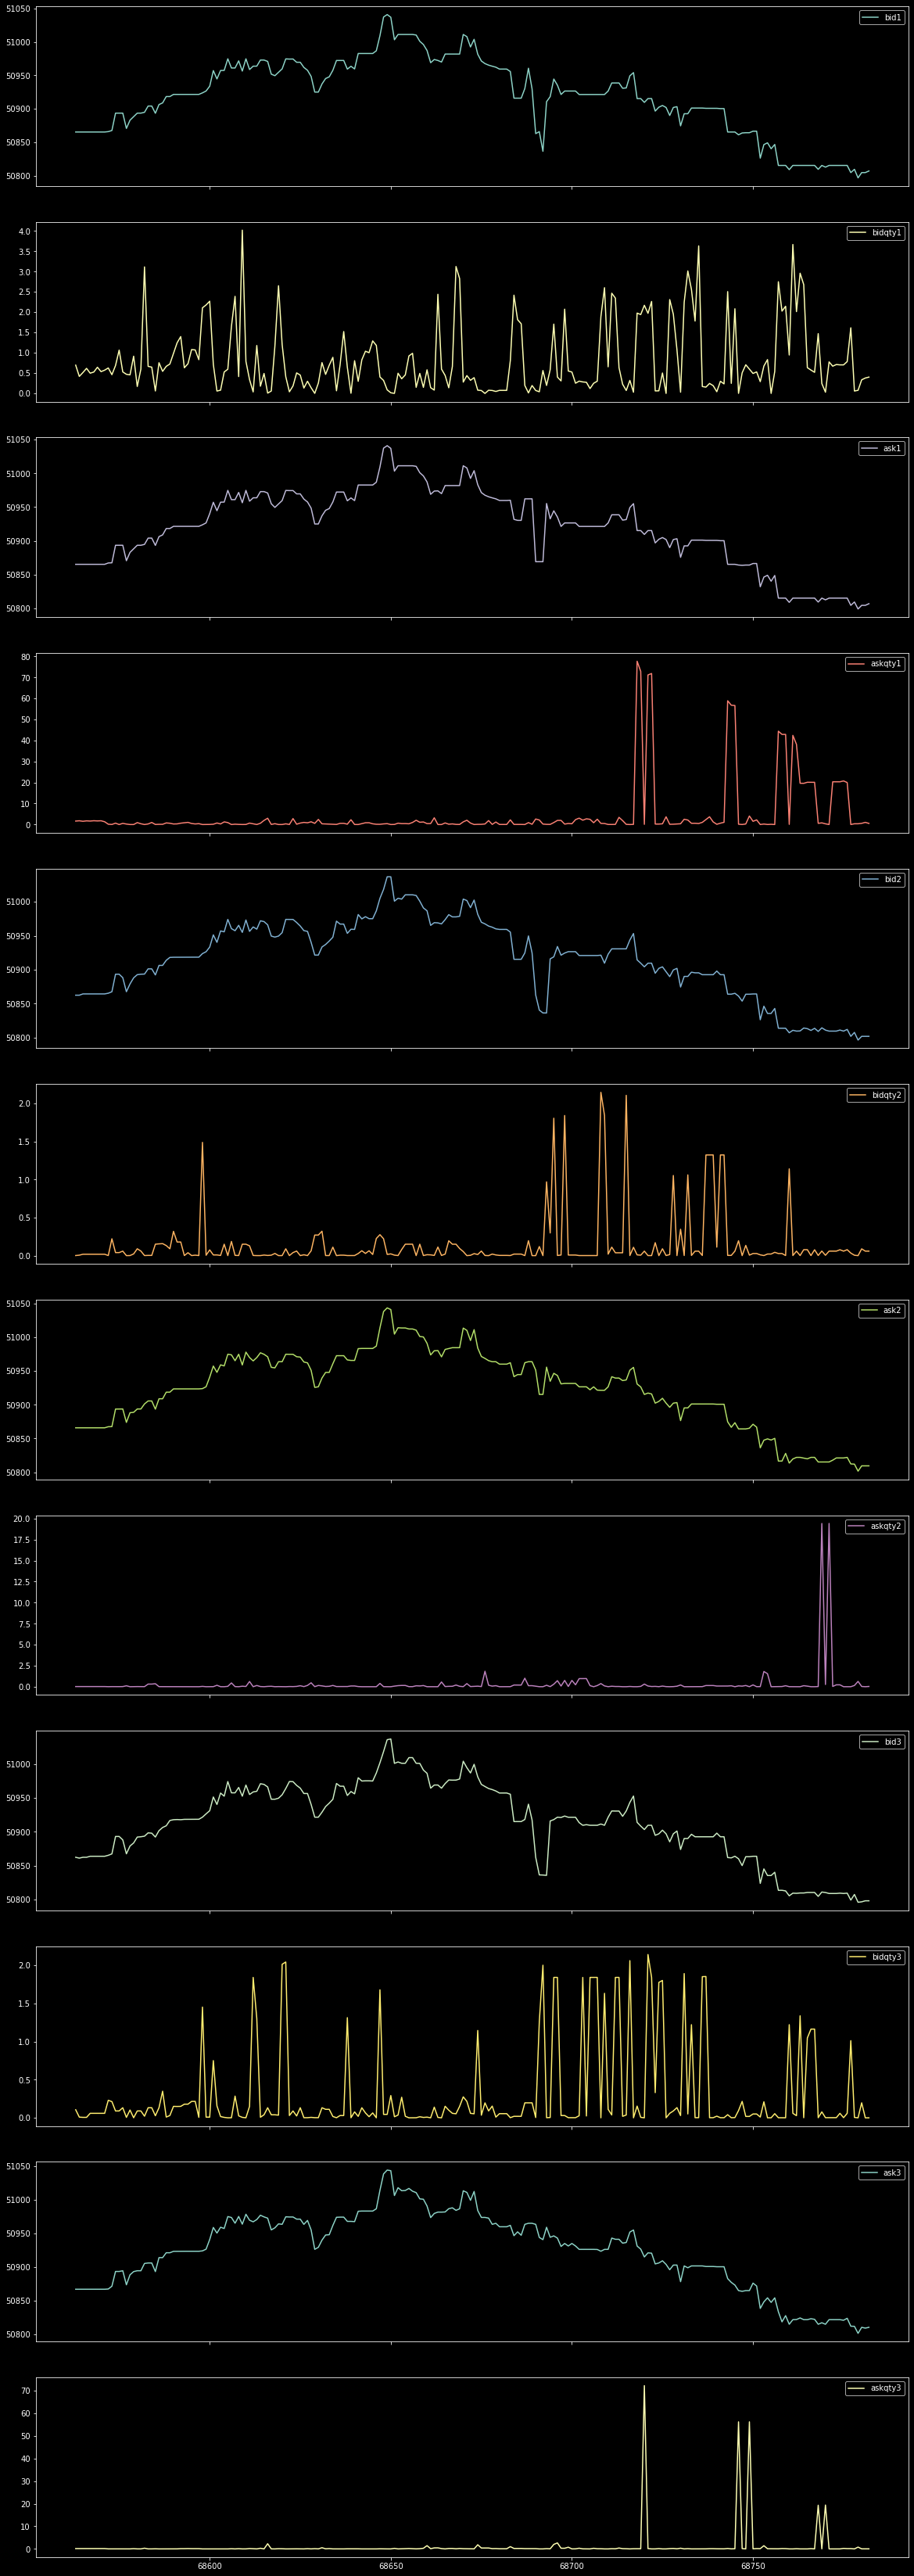

In [40]:
ob_train[68563:68783].drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).plot(subplots=True, figsize=(20, 60))
#Examining the time series around the point where this gap occurs, we can see that there's no especially strange behaviour. 
#So, we can ignore this time gap. 

In [43]:
df1 = ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])[WINDOW_LENGTH-1:].pct_change(HORIZON)[HORIZON:]
#Rows of train where the price increase in horizon seconds was 0.25% or more, or the price decrease was -0.25% or less
#df1 = df1[(df1['bid1'] >= 0.0025) | (df1['bid1'] <= -0.0025)]
#print("Opportunities in train: ", len(df1))
print("Buy opportunities in train: ", np.sum([df1['bid1'] >= THRESHOLD]))
print("Sell opportunities in train", np.sum([df1['bid1'] <= -THRESHOLD]), "\n")

df2 = ob_test.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])[WINDOW_LENGTH-1:].pct_change(HORIZON)[HORIZON:]
#Rows of test where the price increase in horizon seconds was 0.25% or more, or the price decrease was -0.25% or less
#df2 = df2[(df2['bid1'] >= 0.0025) | (df2['bid1'] <= -0.0025)]
#print("Opportunities in test: ", len(df2))
print("Buy opportunities in test:", np.sum([df2['bid1'] >= THRESHOLD]))
print("Sell opportunities in test:", np.sum([df2['bid1'] <= -THRESHOLD]))

Buy opportunities in train:  51
Sell opportunities in train 47 

Buy opportunities in test: 96
Sell opportunities in test: 131


In [ ]:
#Could-do: Get a chart of HORIZON against trade opportunities (movements of 25 bp or more). In deciding the value of HORIZON, there's a tradeoff between predicting far into the future and having more trade opportunities. 

<AxesSubplot:title={'center':'Distribution of shorts'}, ylabel='Count'>

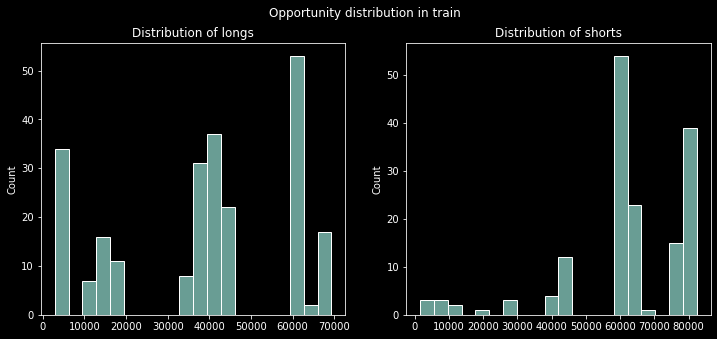

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Opportunity distribution in train")
ax[0].set_title("Distribution of longs")
sns.histplot(df1[df1['bid1'] >= THRESHOLD].index - HORIZON, bins=20, ax=ax[0])
ax[1].set_title("Distribution of shorts")
sns.histplot(df1[df1['bid1'] <= -THRESHOLD].index - HORIZON, bins=20, ax=ax[1])

#If we split into train into train and validation, there might be very few opportunities for shorts in the train set

<AxesSubplot:title={'center':'Correlations between variables'}>

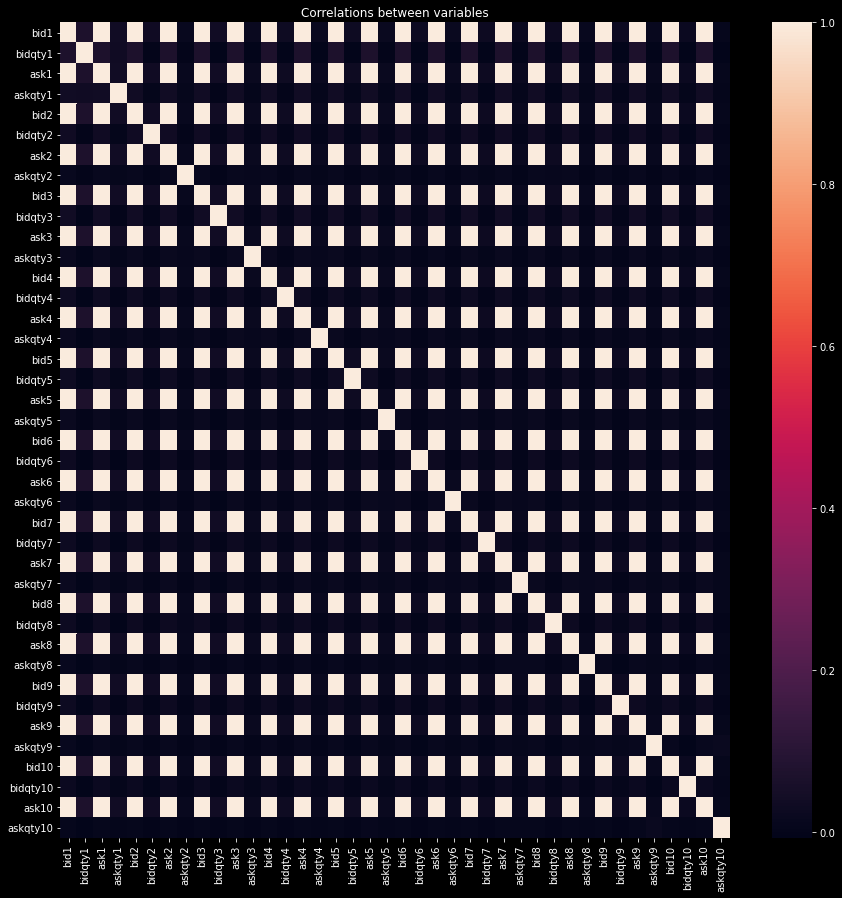

In [ ]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Correlations between variables")
sns.heatmap(ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).corr())

#Prices are perfectly correlated with each other, quantities are perfectly uncorrelated with every other variable
#as we might expect. Not very informative at all. 

<AxesSubplot:title={'center':'In test set'}, xlabel='bid1', ylabel='Count'>

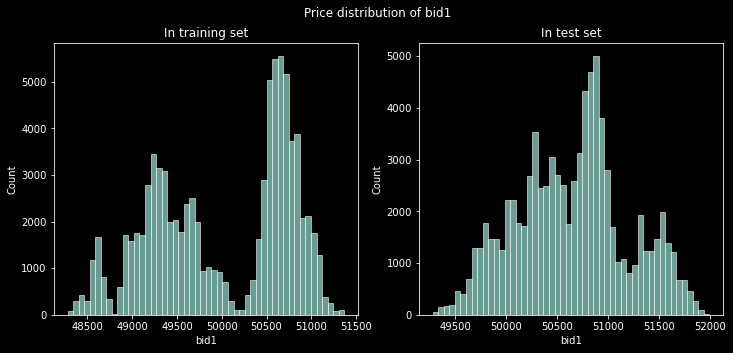

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Price distribution of bid1")
ax[0].set_title("In training set")
sns.histplot(ob_train['bid1'], ax=ax[0], bins=50)
ax[1].set_title("In test set")
sns.histplot(ob_test['bid1'], ax=ax[1], bins=50)

#Price distribution in test set is much closer to a normal distribution

<AxesSubplot:title={'center':'Zoomed in'}, xlabel='bidqty1', ylabel='Count'>

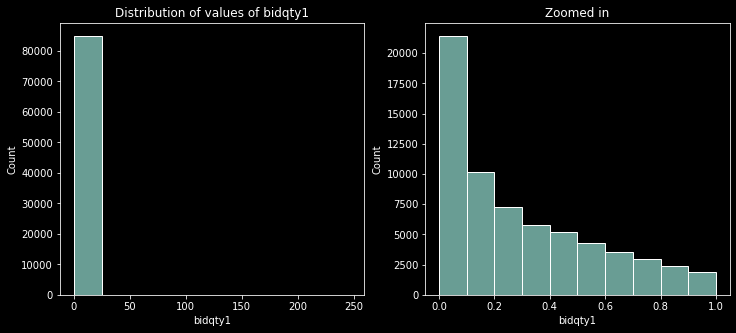

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Distribution of values of bidqty1")
sns.histplot(ob_train['bidqty1'], bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(ob_train['bidqty1'], bins=10, binrange=(0, 1), ax=ax[1])

## Tradebook

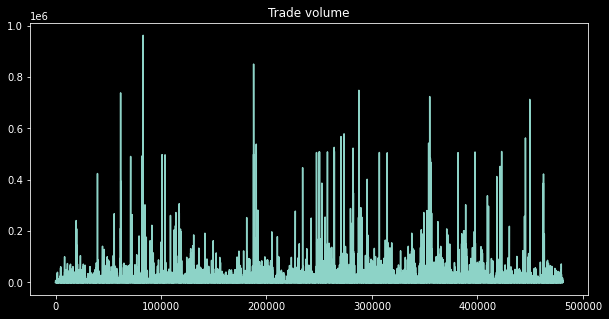

In [ ]:
volume = tb_train['price'] * tb_train['quantity']
plt.figure(figsize=(10, 5))
plt.title("Trade volume")
plt.plot(volume)

<AxesSubplot:title={'center':'Zoomed in'}, ylabel='Count'>

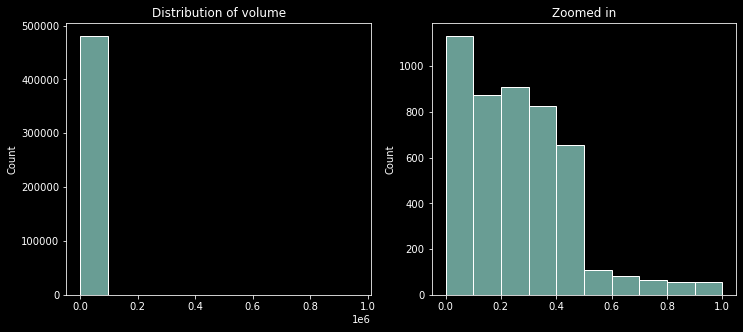

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Distribution of trade volume")
sns.histplot(volume, bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(volume, bins=10, binrange=(0, 1), ax=ax[1])

# Feature Engineering
Before reading the papers, some features that we could add/remove:

Orderbook:
* Use 30-second returns as the target data instead of price (for regression model, this is already the case for the classification model)
* Add spread at the top of the book
* Remove bottom five (or more) levels of price and volume? Though I think I'll leave these in for now and use methods used in the papers (e.g. autoencoders)
* Some kind of readymade sentiment feature? Such modules exist


Tradebook:
* Pseudo-volatility / volume feature which is high when there are many large volume trades placed recently, and is low otherwise (using tradebook data)



In [25]:
#Keep only the top N levels of the limit order book
N = 3
ob_train = ob_train.iloc[:, :(5+N*4)]
ob_test = ob_test.iloc[:, :(5+N*4)]

## Machine_Learning_for_Forecasting_Mid_Price_Movement.pdf
See Table 4 on Page 15 of https://arxiv.org/pdf/1705.03233.pdf (reference 32 in the paper)
* The goal of this paper is to predict the mid-price movement, not the price jumps like our goal, but it's easy to imagine how all of their features could be useful for us. The other concern is that they didn't use LSTMs, but instead a less complex classification algorithm. 

In [ ]:
#Add time-insensitive features
def add_ti_features(df):

    u_5_1 = len(df) * [0]
    u_5_2 = len(df) * [0]

    for i in range(1, N+1):
        df['spread' + str(i)] = df['ask' + str(i)] - df['bid' + str(i)] #spread
        df['mid' + str(i)] = (df['ask' + str(i)] + df['bid' + str(i)]) / 2 #mid

        if i < N:
            df['u3_3_' + str(i+1) + "-" + str(i)] = np.abs(df['ask' + str(i+1)] - df['ask' + str(i)])
            df['u3_4_' + str(i+1) + "-" + str(i)] = np.abs(df['bid' + str(i+1)] - df['bid' + str(i)])

        u_5_1 += df['ask' + str(i)] - df['bid' + str(i)]
        u_5_2 += df['askqty' + str(i)] - df['bidqty' + str(i)]

    df['u3_1'] = df['ask' + str(N)] - df['ask1']
    df['u3_2'] = df['bid1'] - df['bid' + str(N)]

    df['ask_mean'] = df[[x for x in df.columns if x.startswith('ask') and "qty" not in x]].mean(axis=1) / N
    df['bid_mean'] = df[[x for x in df.columns if x.startswith('bid') and "qty" not in x]].mean(axis=1) / N
    df['askqty_mean'] = df[[x for x in df.columns if x.startswith('askqty')]].mean(axis=1) / N
    df['bidqty_mean'] = df[[x for x in df.columns if x.startswith('bidqty')]].mean(axis=1) / N

    return df

ob_train = add_ti_features(ob_train)
ob_test = add_ti_features(ob_test)

<AxesSubplot:title={'center':'Correlations between variables'}>

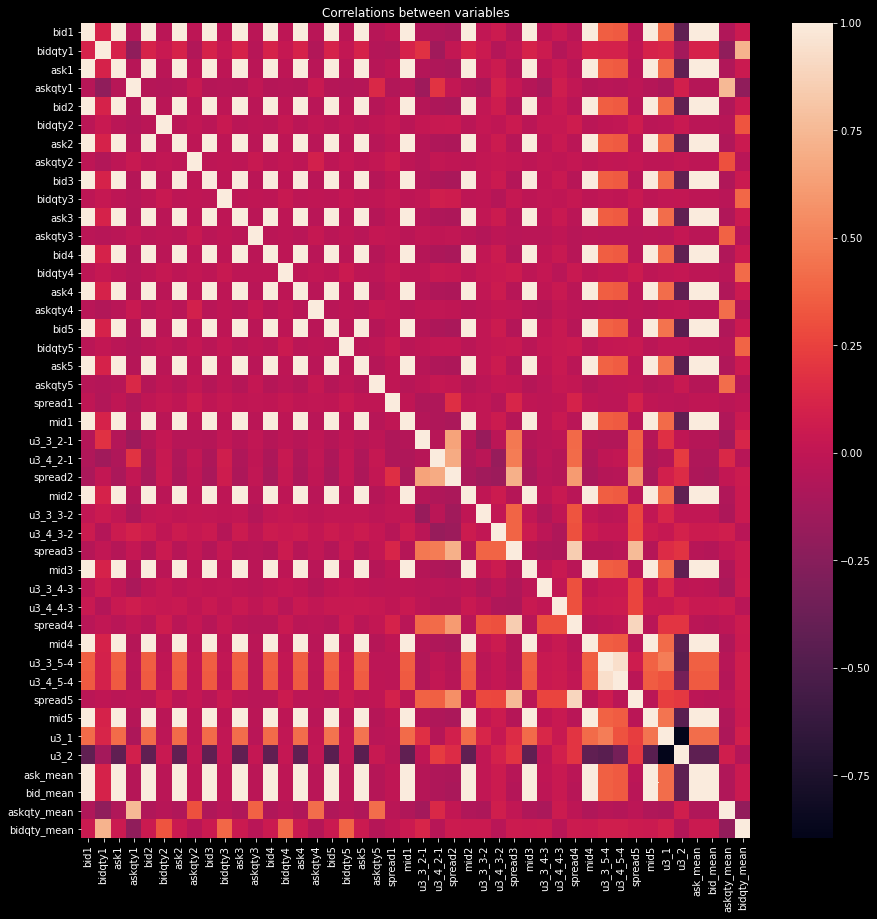

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Correlations between variables")
sns.heatmap(ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).corr())

In [ ]:
def add_ts_features(df):
    return df

ob_train = add_ts_features(ob_train)

# Preprocessing

## Split
Need to split before scaling, to ensure that information from the validation set is not leaking into the training set.

In [26]:
ob_train_train, ob_val = train_test_split(ob_train, test_size=0.2, shuffle=False)

## Scaling

Source: https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

Standardise prices. Normalisation is not suitable, since the time series may trend up or down. Standardisation is also required when data are of different scales; price and volume certainly are of different scales so this is the case.

Assumptions:
* Standardisation requires that you know or are able to accurately estimate the mean and standard deviation of observable values. 
* Standardisation assumes that observations fit a Gaussian distribution:
    * The plot above shows that this doesn't really hold for the prices
    * It certainly doesn't hold for the quantities. So, quantities need to be normalised instead.

Need to normalise new data in the same way as old data, so save scalers and use them on the test set.

In [27]:
#Need to normalise new data in the same way as old data, so use the scaler fit on the training set to scale validation and test sets.
#In the DeepLOB paper it seems that they scale the entire orderbook using a single scaler, so we'll try the same.

def fit_and_scale(df):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    scaler = StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    return df, scaler

def scale_new(df, scaler):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    df = scaler.transform(df)
    return df

train_lob, scaler = fit_and_scale(ob_train_train)
val_lob = scale_new(ob_val, scaler)
test_lob = scale_new(ob_test, scaler)

## Building dataset

Our 'X' data will be the previous **window_length** rows (including the current one) of the the feature set. The 'y' data will be bid1 in the **horizon**th row below the last row of the 'X' data. 

In [28]:
#Source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Drop irrelevant columns
#Reshape data into the shape (batch_size, window_length, features), where batch_size is the maximum possible batch size. 
#The shape of one single sample with window_length=5 and features=40 is (1, 5, 40)
'''
raw: 10, 20, 30, 40, 50, 60

            X				y
Example 1   10, 20, 30		40, 50
Example 2   20, 30, 40		50, 60
Example 3   30, 40, 50		60, 70
'''

def build_ds_regression(raw, window_length, horizon):
    #raw = raw.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])
    #ds = raw.to_numpy()
    ds = raw
    X = []
    y = []
    for i in range(len(ds) - window_length - horizon):
        X_instance, y_instance = ds[i:i+window_length, :], ds[i+window_length:i+window_length+horizon+1, 0]
        X.append(X_instance)
        y.append(y_instance)
    X = np.array(X)
    y = np.array(y) 
    return X, y

In [29]:
#aka time_steps in existing literature. Each prediction is based on the previous window_length rows.
WINDOW_LENGTH = 15
#predict (horizon+1) seconds ahead (on average). Horizon = 0 means predict next second.
HORIZON = 14

X_train, y_train = build_ds_regression(train_lob, WINDOW_LENGTH, HORIZON)
print(X_train.shape, y_train.shape)

X_val, y_val = build_ds_regression(val_lob, WINDOW_LENGTH, HORIZON) #Surely we shouldn't peek into the validation set?
print(X_val.shape, y_val.shape)

X_test, y_test = build_ds_regression(test_lob, WINDOW_LENGTH, HORIZON)
print(X_test.shape, y_test.shape)

(68267, 15, 12) (68267, 15)
(17045, 15, 12) (17045, 15)
(84284, 15, 12) (84284, 15)


# Model Training
We first train a baseline model (for comparison with a trained model), and then actually train a model.


In [30]:
#See https://machinelearningmastery.com/regression-metrics-for-machine-learning/
METRICS = [
      keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),
      keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None),
      keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error", dtype=None), 
      keras.metrics.MeanSquaredLogarithmicError(name="mean_squared_logarithmic_error", dtype=None),
      keras.metrics.CosineSimilarity(name="cosine_similarity", dtype=None, axis=-1),
      keras.metrics.LogCoshError(name="logcosh", dtype=None),
]

def build_regression_model(learning_rate=0.001, window_length=WINDOW_LENGTH, n_features=X_train.shape[2]):
    model = keras.Sequential()
    model.add(layers.LSTM(100, activation='relu', input_shape=(window_length, n_features)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1], activation='linear')) #We want the model to output a real vector, all entries are predictions of bid1 at different timesteps.

    #Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate) #Try stochastic gradient descent as well
    model.compile(loss='mean_squared_error', optimizer = opt, metrics=METRICS) 
    return model

In [31]:
EPOCHS = 10
BATCH_SIZE = 32

# Create a callback that saves the model's weights
checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v3/model1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = build_regression_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               45200     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1515      
Total params: 46,715
Trainable params: 46,715
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Baseline model results
baseline_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(baseline_results[0]))
for i in range(len(baseline_results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(baseline_results[i+1]))

Loss: 1.0351
root_mean_squared_error : 1.0174
mean_absolute_error : 0.9142
mean_absolute_percentage_error : 100.5929
mean_squared_logarithmic_error : 0.2051
cosine_similarity : 0.0811
logcosh : 0.4135


In [33]:
save_weights = False

if save_weights:
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=False, 
        callbacks=[cp_callback, early_stopping],
        verbose=1)
else:
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=False, 
        callbacks=[early_stopping],
        verbose=1)

Epoch 1/10
2134/2134 [==============================] - 32s 15ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 12.7983 - mean_squared_logarithmic_error: 8.3818e-04 - cosine_similarity: 0.9874 - logcosh: 0.0073 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324 - val_mean_absolute_error: 0.1068 - val_mean_absolute_percentage_error: 133.8583 - val_mean_squared_logarithmic_error: 0.0078 - val_cosine_similarity: 0.9566 - val_logcosh: 0.0087
Epoch 2/10
2134/2134 [==============================] - 31s 15ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 10.1116 - mean_squared_logarithmic_error: 4.4293e-04 - cosine_similarity: 0.9932 - logcosh: 0.0013 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373 - val_mean_absolute_error: 0.1132 - val_mean_absolute_percentage_error: 99.7715 - val_mean_squared_logarithmic_error: 0.0076 - val_cosine_simi

In [ ]:
'''
#Convert the history.history dict to a pandas DataFrame and save to csv
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(f"drive/My Drive/modelCheckpoints/History/{model_name}.csv"
'''

'\n#Convert the history.history dict to a pandas DataFrame and save to csv\nhist_df = pd.DataFrame(history.history) \nhist_df.to_csv(f"drive/My Drive/modelCheckpoints/History/{model_name}.csv"\n'

# Model Evaluation

In [ ]:
'''
#Load saved weights
checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v3/model1.ckpt"
model.load_weights(checkpoint_path) #Define and compile the model before executing this line
'''

'\n#Load saved weights\ncheckpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt"\nmodel.load_weights(checkpoint_path) #Define and compile the model before executing this line\n'

In [34]:
#Comparison to baseline
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
for i in range(len(results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(results[i+1]))

Loss: 0.0176
root_mean_squared_error : 0.1327
mean_absolute_error : 0.1119
mean_absolute_percentage_error : 15.7272
mean_squared_logarithmic_error : 0.0008
cosine_similarity : 0.9931
logcosh : 0.0087


In [35]:
#Get predictions from model using test data
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)

predictions = predictions[:, HORIZON] #We only care about the prediction horizon+1 seconds from now, so only keep last columnplt.figure(figsize=(15, 10))

predictions shape: (84284, 15)


## De-Scaling
I think data needs to be returned to the original scale, so that the prices make sense.

In [36]:
#de-standardise the data, i.e. return to original scale.
predictions = (np.sqrt(scaler.var_[0]) * predictions) + scaler.mean_[0]

Correct predictions:  45 || Total predictions:  13342 

Accuracy:  0.003372807675011243 

Missed opportunities:  182 || Total opportunities:  227 

MSE:  [12683.53597968]
MAE:  [85.89833878]
RMSE:  [112.62120573]
R-squared:  [0.95731073]


Text(0.5, 1.0, 'Red: Real     Green: Predicted')

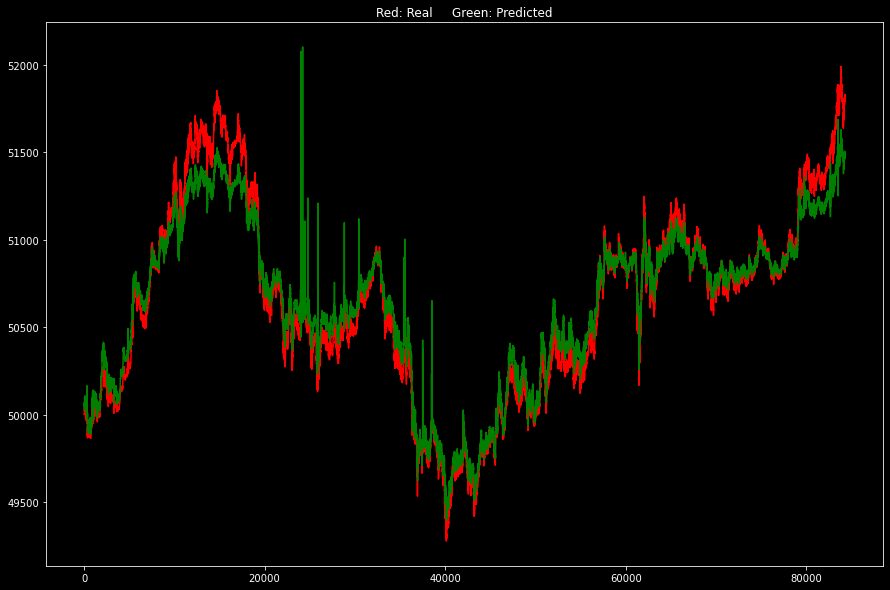

In [37]:
def evaluate_regression_model(ob_test, predictions):
    #For use with regression model
    df_eval = ob_test[['timestamp', 'bid1']].rename(columns={"bid1": "observed"})[WINDOW_LENGTH+HORIZON:].reset_index(drop=True)
    predictions = predictions.reshape(len(predictions), 1)

    observed = np.array(df_eval['observed'])
    observed = observed.reshape(len(observed), 1)
    df_eval['observed'] = observed 

    #The model thinks this series contains the values of bid1 at the corresponding timestamps
    #predictions has already been de-standardised above
    df_eval['predicted'] = predictions 

    #price when prediction made, corresponding timestamp in df_eval is different to timestamp when prediction was actually made.
    pwpm = np.array(ob_test['bid1'][WINDOW_LENGTH-1:len(ob_test)-HORIZON-1])
    pwpm = pwpm.reshape(len(pwpm), 1)
    df_eval['pwpm'] = pwpm

    ai = observed - pwpm #actual increase
    df_eval['act_inc'] = ai

    pi = predictions - pwpm #predicted increase
    df_eval['pred_inc'] = pi

    api = (ai.reshape(len(ai), 1)/np.abs(pwpm)) #actual percentage increase in decimal
    df_eval['act_pct_inc'] = api

    ppi = (pi.reshape(len(pi), 1)/np.abs(pwpm)) #predicted percentage increase in decimal
    df_eval['pred_pct_inc'] = ppi

    #An increase of 25 basis points is equivalent to an increase of 0.25%. 
    threshold = 0.0025

    #Precision = number of correct predictions / total number of predictions
    n_true_positives = len(df_eval[(df_eval['act_pct_inc'] >= threshold) & (df_eval['pred_pct_inc'] >= threshold)]) + len(df_eval[(df_eval['act_pct_inc'] <= -threshold) & (df_eval['pred_pct_inc'] <= -threshold)])
    n_predictions = len(df_eval[df_eval['pred_pct_inc'] >= threshold]) + len(df_eval[df_eval['pred_pct_inc'] <= -threshold])
    print("Correct predictions: ", n_true_positives, "||", "Total predictions: ", n_predictions, "\n")

    #Precision = n_true_positives / n_true_positives + n_false_positives
    #n_false_positives = len(df_eval[(df_eval['act_pct_inc'] <= threshold) & (df_eval['pred_pct_inc'] >= threshold)]) + len(df_eval[(df_eval['act_pct_inc'] >= -threshold) & (df_eval['pred_pct_inc'] <= -threshold)])

    if n_predictions > 0:
        accuracy = n_true_positives / n_predictions
        print("Accuracy: ", accuracy, "\n")

        #precision = n_true_positives / (n_true_positives + n_false_positives)
        #print("Precision: ", precision, "\n")
    else:
        print("No positive predictions made", "\n")

    #Model predicts price won't rise by 25bp, so we don't trade, but the price does rise by 25bp
    n_missed_opportunities = len(df_eval[(df_eval['act_pct_inc'] >= threshold) & (df_eval['pred_pct_inc'] < threshold)]) + len(df_eval[(df_eval['act_pct_inc'] <= -threshold) & (df_eval['pred_pct_inc'] > -threshold)])
    n_opportunities = len(df_eval[df_eval['act_pct_inc'] >= threshold]) + len(df_eval[df_eval['act_pct_inc'] <= -threshold])
    print("Missed opportunities: ", n_missed_opportunities, "||", "Total opportunities: ", n_opportunities, "\n")

    #Compute other metrics
    mse = np.power((predictions - observed), 2).sum(axis=0) / len(predictions)
    mae = np.abs(predictions - observed).sum(axis=0)/len(predictions)
    rmse = np.sqrt(mse)

    ybar = np.tile(observed.sum(axis=0)/len(observed), (len(observed), 1))
    tss = np.power(observed - ybar, 2).sum(axis=0)
    r2 = 1 - (len(predictions)*mse / tss)

    print("MSE: ", mse)
    print("MAE: ", mae)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)

    return df_eval

df_eval = evaluate_regression_model(ob_test, predictions)

plt.figure(figsize=(15, 10))
plt.plot(df_eval.index.values, df_eval['observed'], color='red')
plt.plot(df_eval.index.values, df_eval['predicted'], color='green')
plt.title("Red: Real     Green: Predicted")